In [1]:
import numpy as np
import os
import pickle
from IPython.display import clear_output
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.rcParams['figure.figsize'] = [15, 5]
import sys
sys.path.insert(1, os.getcwd()+"/../..") # Not needed if you installed SyMBac using pip
from SyMBac.colony_simulation import ColonySimulation
from SyMBac.colony_renderer import ColonyRenderer
from SyMBac.PSF import PSF_generator
import numpy as np
from scipy import fftpack
from scipy.ndimage import gaussian_filter
from utils import GetSourcePts, GetMidPts, InverseMatrix, ApproxPSFBesselOptimise, GetAvgIntensityWithMask
import cv2
import pandas as pd

#Remove directory data if it exists
if os.path.exists("data"):
    os.system("rm -rf data")

/home/boomalope/anaconda3/envs/symbac/SyMBac/tests/dx_test_env/../../SyMBac/colony_simulation.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [ ]:
TRIALS = 100
PATH = os.getcwd() 
SAVED_FOLDER = "/no_offset"
ASSUMED_NOISE_LEVEL = 1e7

In [ ]:
#Try to open data.csv

try:
    df = pd.read_csv(PATH+SAVED_FOLDER+"/data.csv")
except:
    column_headers = ["Convolution: Simple Averaging", "Convolution: All Pixels", "Convolution: Mid Pts", "kernel.radius", "kernel.wavelength", "kernel.NA", "kernel.n", "kernel.resize_amount", "kernel.pix_mic_conv", "kernel.apo_sigma", "kernel.mode", "kernel.condenser", "kernel.offset", "colony.cellmodeller_model", "colony.max_cells", "colony.pix_mic_conv", "colony.resize_amount"]
    df = pd.DataFrame([], columns=column_headers)


In [ ]:
print(df["Convolution: Simple Averaging"].mean())
print(df["Convolution: All Pixels"].mean())
print(df["Convolution: Mid Pts"].mean())

plt.scatter(range(len(df)), df["Convolution: Simple Averaging"], color="black")
plt.scatter(range(len(df)), df["Convolution: All Pixels"], color="red")
plt.scatter(range(len(df)), df["Convolution: Mid Pts"], color="blue")

In [4]:
for t in range(TRIALS):

    #Create directory data if it does not exist
    NEW_FOLDER = PATH+SAVED_FOLDER+"/"+str(len(df))
    if not os.path.exists(NEW_FOLDER):
        os.makedirs(NEW_FOLDER)
        
    print("Current trial: ", t)
    my_kernel = PSF_generator(
        radius = 100, 
        wavelength = 0.75, 
        NA = 1.45, 
        n = 1.4, 
        resize_amount = 3,
        pix_mic_conv = 0.065, 
        apo_sigma = 8, 
        mode="simple fluo", 
        condenser = "Ph3",
        offset = 0.0
    )
    my_kernel.calculate_PSF()

    while True:
        try:
            colonysim = ColonySimulation(
                cellmodeller_model= 'cellmodeller_ex1_simpleGrowth_modified.py',
                max_cells = 7,
                pix_mic_conv = 0.065,
                resize_amount = 3,
                save_dir = "dx_test/",
            )

            colonysim.run_cellmodeller_sim(num_sim=1)
            colonysim.get_simulation_dirs()
            pickles = colonysim.get_simulation_pickles()
            colonysim.get_max_scene_size()

            FRAME_CNT = len(pickles[-1])
            colonysim.draw_simulation_OPL(n_jobs = 1, FL=True, density = 0.1, random_distribution = "uniform", distribution_args = (0.9, 3))
            break
        except:
            #Remove directory data if it exists
            if os.path.exists("data"):
                os.system("rm -rf data")
            clear_output(wait=True)
            pass

    my_renderer = ColonyRenderer(colonysim, my_kernel)
    out = my_renderer.render_scene(-1)
    psf = my_kernel.get_fluorescence_kernel(my_kernel.wavelength,my_kernel.NA,my_kernel.n,my_kernel.radius,my_kernel.scale)

    #Try reading for image with multiple possible names (Hacky solution)
    try:
        ori = mpimg.imread(PATH + '/data/scenes/00{frame}.png'.format(frame=FRAME_CNT))
        mask = mpimg.imread(PATH + '/data/masks/00{frame}.png'.format(frame=FRAME_CNT))
    except:
        ori = mpimg.imread(PATH + '/data/scenes/0{frame}.png'.format(frame=FRAME_CNT))
        mask = mpimg.imread(PATH + '/data/masks/0{frame}.png'.format(frame=FRAME_CNT))    

    with open(NEW_FOLDER+'/ori.pkl', 'wb') as file: 
        pickle.dump(ori, file)
    with open(NEW_FOLDER+'/mask.pkl', 'wb') as file: 
        pickle.dump(mask, file)
    with open(NEW_FOLDER+'/out.pkl', 'wb') as file: 
        pickle.dump(out, file)
    with open(NEW_FOLDER+'/psf.pkl', 'wb') as file: 
        pickle.dump(psf, file)

    #Run pipeline

    ori = ori/max(ori.flatten())
    mask = mask/max(mask.flatten())
    out = out/max(out.flatten())

    #Apply gaussian filter to out
    outBlur = gaussian_filter(out, sigma=1)

    #Resize mask to match out
    maskRescale = cv2.resize(mask, outBlur.shape[::-1], interpolation = cv2.INTER_NEAREST)

    #IMPT: All mask values are set to one
    maskUnit = maskRescale.copy()

    for i in range(len(maskUnit)):
        for j in range(len(maskUnit[0])):
            if (maskUnit[i][j] != 0):
                maskUnit[i][j] = 1
    
    # Compute the 2d FFT of the input image
    oriFreq = fftpack.fft2(ori)
    maskFreq = fftpack.fft2(maskUnit)
    outFreq = fftpack.fft2(outBlur)

    # Shift the zero-frequency component to the center of the spectrum.
    oriFreq = fftpack.fftshift(oriFreq)
    maskFreq = fftpack.fftshift(maskFreq)
    outFreq = fftpack.fftshift(outFreq)

    #Transform mask.shape into odd values

    psfShape = [0,0]
    psfShape[0] = mask.shape[0] + 1 if mask.shape[0] % 2 == 0 else mask.shape[0]
    psfShape[1] = mask.shape[1] + 1 if mask.shape[1] % 2 == 0 else mask.shape[1]

    psfFreqMask= outFreq * np.conj(maskFreq) / (np.abs(maskFreq)**2 + ASSUMED_NOISE_LEVEL/np.max(np.abs(maskFreq)**2))
    psfMask = fftpack.ifft2(psfFreqMask, shape=psfShape)
    psfMask = fftpack.fftshift(psfMask)
    psfModel = ApproxPSFBesselOptimise(np.abs(psfMask))

    sourcePts = GetSourcePts(mask)
    sourcePtsRescale = GetSourcePts(maskRescale)
    recoveredImageAllPixels = InverseMatrix(outBlur, maskRescale, sourcePtsRescale, adjPts=0, learningRate = 1, psf=psfModel)
    midPts = GetMidPts(maskRescale)
    recoveredImageMidPts = InverseMatrix(outBlur, maskRescale, midPts, adjPts=0, learningRate = 1, psf=psfModel)

    average_original_mask, average_original_intensity = GetAvgIntensityWithMask(ori,mask,sourcePts)
    average_avg_output_mask, average_avg_output_intensity = GetAvgIntensityWithMask(out,maskRescale,sourcePtsRescale)
    average_all_pixels_mask, average_all_pixels_intensity = GetAvgIntensityWithMask(recoveredImageAllPixels,maskRescale,sourcePtsRescale)
    average_mid_pts_mask, average_mid_pts_intensity = GetAvgIntensityWithMask(recoveredImageMidPts,maskRescale,midPts)

    # Sort average_original_mask into ascending order and sort average_original_intensity accordingly
    average_original_mask, average_original_intensity = zip(*sorted(zip(average_original_mask, average_original_intensity)))
    average_avg_output_mask, average_avg_output_intensity = zip(*sorted(zip(average_avg_output_mask, average_avg_output_intensity)))
    average_all_pixels_mask, average_all_pixels_intensity = zip(*sorted(zip(average_all_pixels_mask, average_all_pixels_intensity)))
    average_mid_pts_mask, average_mid_pts_intensity = zip(*sorted(zip(average_mid_pts_mask, average_mid_pts_intensity)))

    for i in range(len(average_original_mask)):
        assert(average_original_mask[i] == average_avg_output_mask[i])
        assert(average_original_mask[i] == average_all_pixels_mask[i])
        assert(average_original_mask[i] == average_mid_pts_mask[i])

    correlation_avg_output = np.corrcoef(average_original_intensity,average_avg_output_intensity)[0][1]
    correlation_all_pixels = np.corrcoef(average_original_intensity,average_all_pixels_intensity)[0][1]
    correlation_mid_pts = np.corrcoef(average_original_intensity,average_mid_pts_intensity)[0][1]

    print("Simple Averaging: ", correlation_avg_output)
    print("All Pixels: ", correlation_all_pixels)
    print("Mid Pts: ", correlation_mid_pts)

    all_impt_info = []
    all_impt_info.append(correlation_avg_output)
    all_impt_info.append(correlation_all_pixels)
    all_impt_info.append(correlation_mid_pts)

    all_impt_info.append(my_kernel.radius)
    all_impt_info.append(my_kernel.wavelength)
    all_impt_info.append(my_kernel.NA)
    all_impt_info.append(my_kernel.n)
    all_impt_info.append(my_kernel.resize_amount)
    all_impt_info.append(my_kernel.pix_mic_conv)
    all_impt_info.append(my_kernel.apo_sigma)
    all_impt_info.append(my_kernel.mode)
    all_impt_info.append(my_kernel.condenser)
    all_impt_info.append(my_kernel.offset)

    all_impt_info.append(colonysim.cellmodeller_model)
    all_impt_info.append(colonysim.max_cells)
    all_impt_info.append(colonysim.pix_mic_conv)
    all_impt_info.append(colonysim.resize_amount)    

    #Add all impt info to df
    df.loc[len(df)] = all_impt_info
    df.to_csv(PATH+SAVED_FOLDER+"/data.csv", index=False)

    #Remove directory data if it exists
    if os.path.exists("data"):
        os.system("rm -rf data")
    
    #Clear Jupyter output
    clear_output(wait=True)



Creating directory data/dx_test/


KeyboardInterrupt: 

0.856171845183171
0.9837899155063238
0.9307525073755413


/home/boomalope/anaconda3/envs/symbac/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/boomalope/anaconda3/envs/symbac/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/boomalope/anaconda3/envs/symbac/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/boomalope/anaconda3/envs/symbac/lib/python3.11/sit

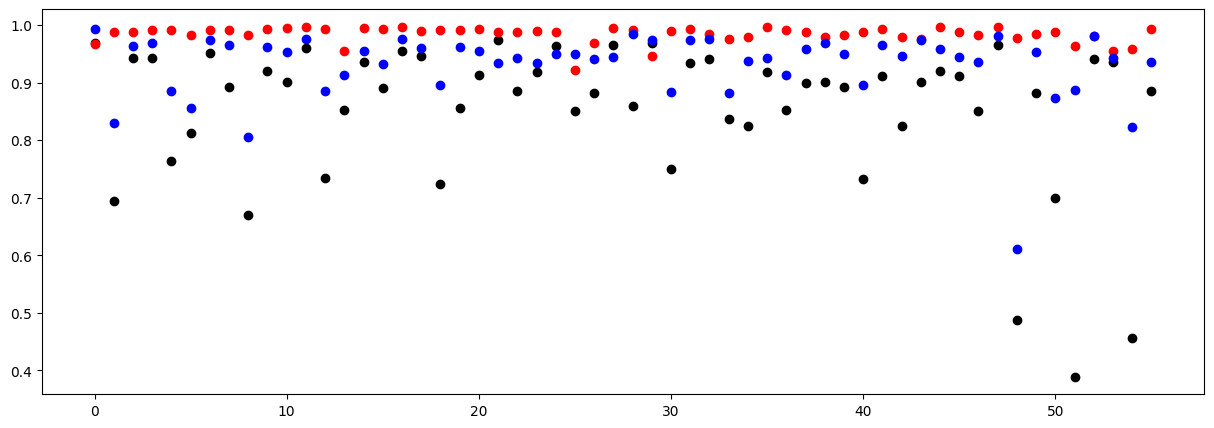

In [6]:
print(df["Convolution: Simple Averaging"].mean())
print(df["Convolution: All Pixels"].mean())
print(df["Convolution: Mid Pts"].mean())

plt.scatter(range(len(df)), df["Convolution: Simple Averaging"], color="black")
plt.scatter(range(len(df)), df["Convolution: All Pixels"], color="red")
plt.scatter(range(len(df)), df["Convolution: Mid Pts"], color="blue")